# This notebook will clean and explore the dataset to then start creating models off of it, to the chosen problems.

#### Loading in the dataset and initial exploration

In [3]:
#if using kaggle api 

#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("piterfm/massive-missile-attacks-on-ukraine")

#print("Path to dataset files:", path)

In [97]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme (style="darkgrid")

In [98]:
# from direct download

df = pd.read_csv("Datasets/missile_attacks_daily.csv")

dataset = df

In [99]:
dataset.head()

,time_start,time_end,model,launch_place,target,carrier,launched,destroyed,not_reach_goal,cross_border_belarus,back_russia,still_attacking,affected region,destroyed_details,launched_details,launch_place_details,source
0,2025-04-12 20:30,2025-04-13 08:30,Shahed-136/131,Primorsko-Akhtarsk and Kursk oblast and Oryol ...,Ukraine,NaN,55.0,43.0,12.0,NaN,NaN,NaN,NaN,"{'south': 5, 'north': NaN, 'center': NaN}",NaN,NaN,kpszsu/posts/pfbid02kUsqDs3iG64k3hAmSxBZdcxby3...
1,2025-04-11 20:00,2025-04-12 09:00,Shahed-136/131,Primorsko-Akhtarsk and Kursk oblast and Millerovo,Ukraine,NaN,88.0,56.0,24.0,NaN,NaN,NaN,"['Kharkiv oblast', 'Kyiv oblast', 'Dnipropetro...","{'south': 18, 'east': 23, 'north': NaN, 'cente...",NaN,NaN,kpszsu/posts/pfbid02Xv7nLE4XQdpefC58eM3AJjJ2go...
2,2025-04-12,2025-04-12,Молнія,NaN,south,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PvKPivden/posts/pfbid02uLbqwDKZJtV2mZurSjHtUnu...
3,2025-04-12,2025-04-12,Lancet,NaN,south,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PvKPivden/posts/pfbid02uLbqwDKZJtV2mZurSjHtUnu...
4,2025-04-10 09:00,2025-04-11 09:00,Shahed-136/131,Primorsko-Akhtarsk and Kursk oblast and Oryol ...,Ukraine,NaN,39.0,24.0,13.0,NaN,NaN,NaN,"['Dnipropetrovsk oblast', 'Donetsk oblast', 'Z...","{'south': 1, 'east': 6, 'north': NaN, 'center'...",NaN,NaN,kpszsu/posts/pfbid02hjDCh6M1JaJDcQPD9gPSSGU2Jt...


In [100]:
len(df)

2322

In [101]:
df.columns

Index(['time_start', 'time_end', 'model', 'launch_place', 'target', 'carrier',
       'launched', 'destroyed', 'not_reach_goal', 'cross_border_belarus',
       'back_russia', 'still_attacking', 'affected region',
       'destroyed_details', 'launched_details', 'launch_place_details',
       'source'],
      dtype='object')

In [102]:
# Viewing the datatypes of the dataset for cleaning
df.dtypes

time_start               object
time_end                 object
model                    object
launch_place             object
target                   object
carrier                  object
launched                float64
destroyed               float64
not_reach_goal          float64
cross_border_belarus    float64
back_russia             float64
still_attacking         float64
affected region          object
destroyed_details        object
launched_details         object
launch_place_details     object
source                   object
dtype: object

## Cleaning the dataset

#### Convert time_start and time_end to datetime

In [103]:
# backing up original string values
df['raw_time_start'] = df['time_start']
df['raw_time_end'] = df['time_end']


# Convert to datetime
df['time_start'] = pd.to_datetime(df['time_start'], errors='coerce')
df['time_end'] = pd.to_datetime(df['time_end'], errors='coerce')

# Function to replace missing time to a default of 6am if date is still valid
def default_missing_time(parsed_dt, original_str):
    if pd.isna(parsed_dt):
        return pd.NaT
    # If orignal string has no valid time info set default to 6am
    if ':' not in str(original_str):
        return parsed_dt.replace(hour=6, minute=0, second=0, microsecond=0)
    return parsed_dt # Keep as-is if time was specified

# Apply the function to each row
df['time_start'] = [
    default_missing_time(parsed, raw)
    for parsed, raw in zip(df['time_start'], df['raw_time_start'])
]

df['time_end'] = [
    default_missing_time(parsed, raw)
    for parsed, raw in zip(df['time_end'], df['raw_time_end'])
]

# Drop the temporary raw columns if not needed
df.drop(columns=['raw_time_start', 'raw_time_end'], inplace=True)


In [104]:
# Verifying the changes
print(df[['time_start', 'time_end']].head())
print(df.dtypes) # time_start and time_end should now be datetime64[ns]

           time_start            time_end
0 2025-04-12 20:30:00 2025-04-13 08:30:00
1 2025-04-11 20:00:00 2025-04-12 09:00:00
2                 NaT                 NaT
3                 NaT                 NaT
4 2025-04-10 09:00:00 2025-04-11 09:00:00
time_start              datetime64[ns]
time_end                datetime64[ns]
model                           object
launch_place                    object
target                          object
carrier                         object
launched                       float64
destroyed                      float64
not_reach_goal                 float64
cross_border_belarus           float64
back_russia                    float64
still_attacking                float64
affected region                 object
destroyed_details               object
launched_details                object
launch_place_details            object
source                          object
dtype: object


In [105]:
# calculating the amount of nat (Not a Time) values in the two columns
total_rows = len(df)

# For time_start
nat_start_count = df['time_start'].isna().sum()
nat_start_pct = (nat_start_count / total_rows) * 100

# For time_end
nat_end_count = df['time_end'].isna().sum()
nat_end_pct = (nat_end_count / total_rows) * 100

print(f"time_start: {nat_start_count} NaT values ({nat_start_pct:.2f}%)")
print(f"time_end: {nat_end_count} NaT values ({nat_end_pct:.2f}%)")


time_start: 1592 NaT values (68.56%)
time_end: 819 NaT values (35.27%)


# Exploring the dataset

This graph shows Missile launched and UAVs vs Destroyed
Overall trend:

    There's a dramatic increase in missile/UAV activity starting around mid/late 2024.

    This shows a clear escalation in attacks.

2. Intercept effectiveness:

    The destroyed line follows the launched line fairly closely, but:

        In earlier periods, they're often very close — indicating high interception rates.

        In the more recent months (late 2024–early 2025), the gap between launched and destroyed widens, suggesting:

            Either more missiles are getting through.

            Or defenses are being overwhelmed.

            Or simply more launched than before — harder to keep up.

3. Attack waves:

    You can spot waves or cycles of intensity — peaks every few weeks.

    Could be tied to strategic events, weather conditions, or specific campaigns.

In [106]:
df_weekly = df.set_index('time_start').resample('W')[['launched', 'destroyed']].sum().fillna(0)

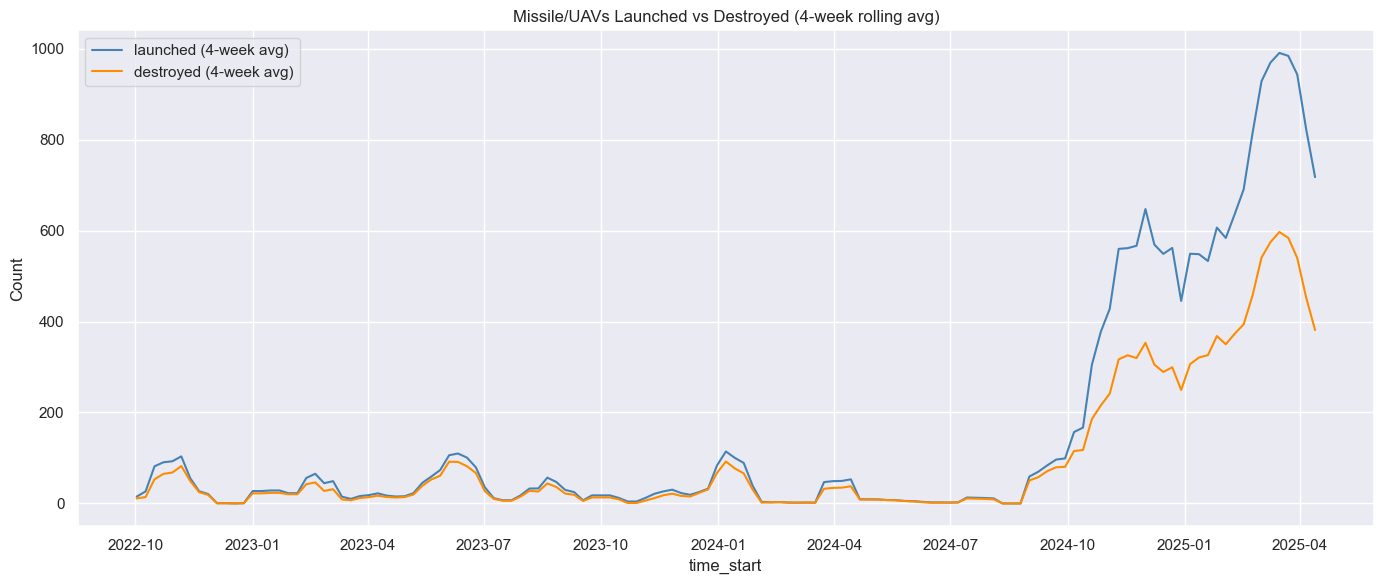

In [107]:
# 4 week rolling average (adjust window for different smoothing)
weekly_smoothed = df_weekly.rolling(window=4, min_periods=1).mean()

# plotting launch vs destroyed over time
plt.figure(figsize=(14, 6))
plt.plot(weekly_smoothed.index, weekly_smoothed['launched'], label='launched (4-week avg)' , color='steelblue')
plt.plot(weekly_smoothed.index, weekly_smoothed['destroyed'], label='destroyed (4-week avg)', color='darkorange')
plt.title("Missile/UAVs Launched vs Destroyed (4-week rolling avg)")
plt.xlabel("time_start")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Verifying the amount of usable data from the affected region column

#### Shown as a percentage flagging either empty or NaT

As the amount of usable data is highly limited for this column leading to my initial plan changing from trying to solve the problem of most attacked region to most targeted region as this contains vastly more data that is usable 

In [108]:
# calculating the amount of nat (Not a Time) values in the two columns
total_rows = len(df)

# For affected region
nat_start_count = df['affected region'].isna().sum()
nat_start_pct = (nat_start_count / total_rows) * 100


print(f"affected region: {nat_start_count} NaT values ({nat_start_pct:.2f}%)")


affected region: 2249 NaT values (96.86%)


#### Performing the same checks on the target column

##### because of the amount of generic values in this column consideration for how these should be dealt with is critical

In [109]:
# Calculating the amount of unique targets and Calculating the total rows in affected target column
unique_count = df['target'].nunique()
print(len(df['target']),'total rows in the target column.',f"{unique_count} of them are unique values.")

count = df['target'].str.lower().str.count('ukraine').sum()
print('of the',(len(df['target'])),'total rows',f"{count} are generic Ukraine values")


2322 total rows in the target column. 99 of them are unique values.
of the 2322 total rows 857.0 are generic Ukraine values


In [110]:
# calculating the amount of nat (Not a Time) values in the two columns
total_rows = len(df)

# For affected region
nat_start_count = df['target'].isna().sum()
nat_start_pct = (nat_start_count / total_rows) * 100


print(f"targets: {nat_start_count} NaT values ({nat_start_pct:.2f}%)")

targets: 29 NaT values (1.25%)


##### Bar chart showing the target regions

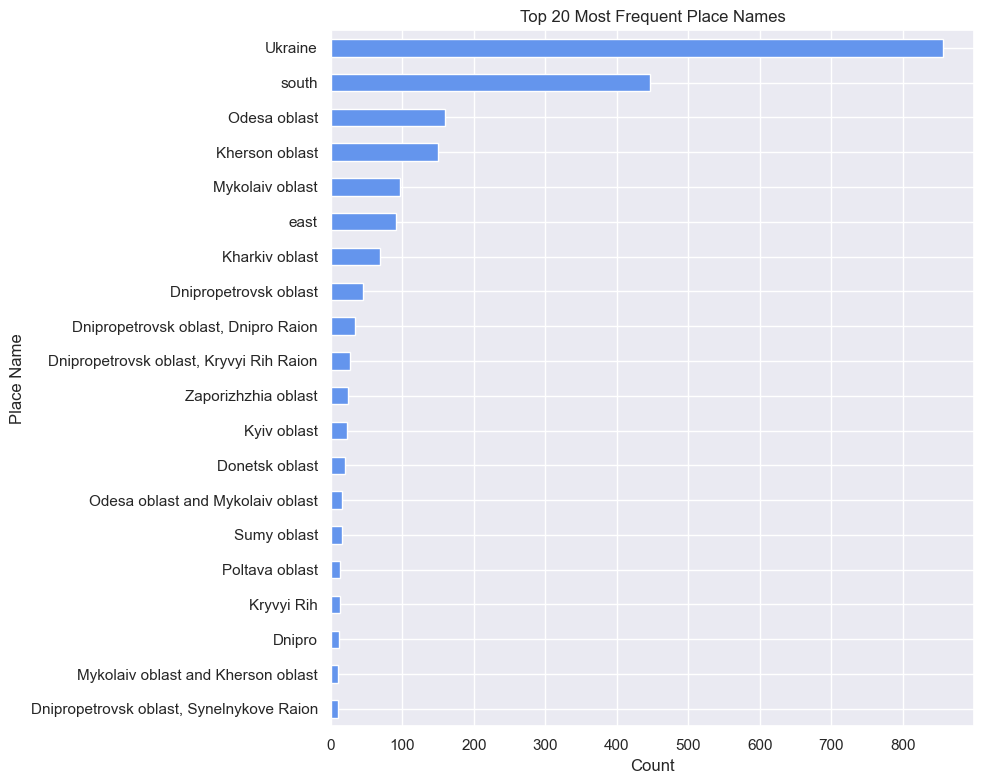

In [111]:
top_places = df['target'].value_counts().head(20)
top_places.plot(kind='barh', figsize=(10, 8), color='cornflowerblue')

plt.xlabel('Count')
plt.ylabel('Place Name')
plt.title('Top 20 Most Frequent Place Names')
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()


from the skewed data of target with the default if unknown being just Ukraine this value must be removed to create an accurate model.

# this may be the problem

In [118]:
# Drop rows where 'target' is NaN (but keep all other columns)
df = df.dropna(subset=['target'])

# Remove rows where 'target' contains 'ukraine' (case-insensitive)
df = df[~df['target'].str.contains('ukraine', case=False, na=False)]


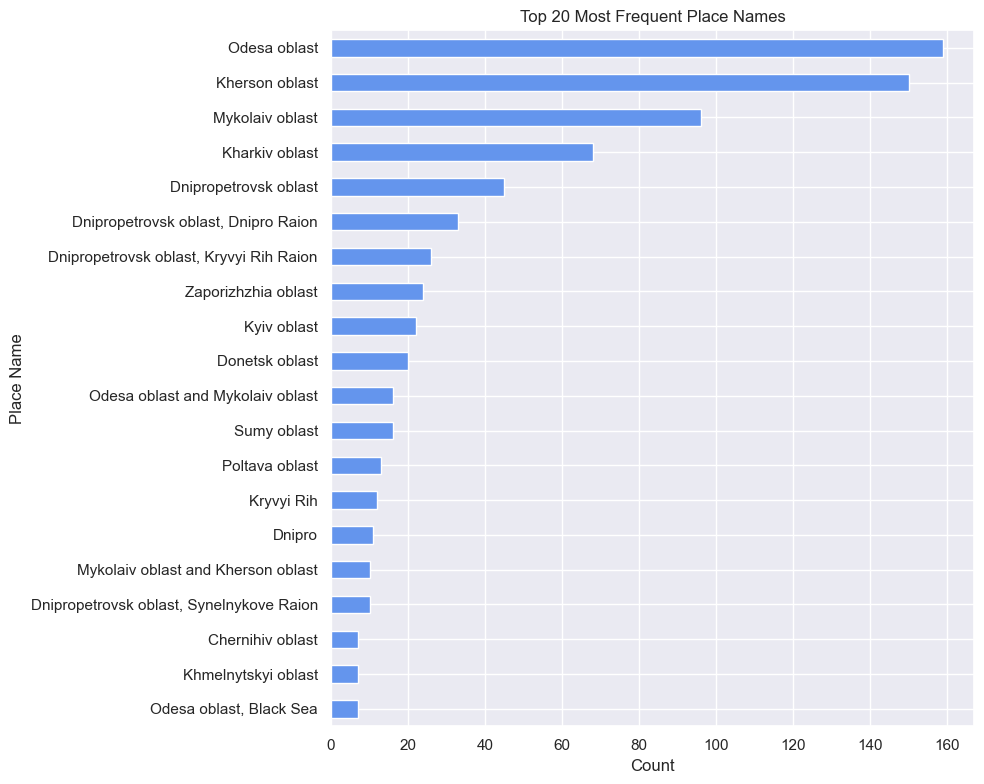

In [119]:
top_places = df['target'].value_counts().head(20)
top_places.plot(kind='barh', figsize=(10, 8), color='cornflowerblue')

plt.xlabel('Count')
plt.ylabel('Place Name')
plt.title('Top 20 Most Frequent Place Names')
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()


using a bar chart to visualize how much of the data is generic vs specific for K-means.

In [113]:
# Filter out generic-only labels for clustering
generic_labels = ['south', 'east', 'north', 'west', 'central']
df_kmeans = df[~df['target'].str.lower().isin(generic_labels)]


The bart chart makes it clear that without the generic data enough specific usable data remains for K-means.

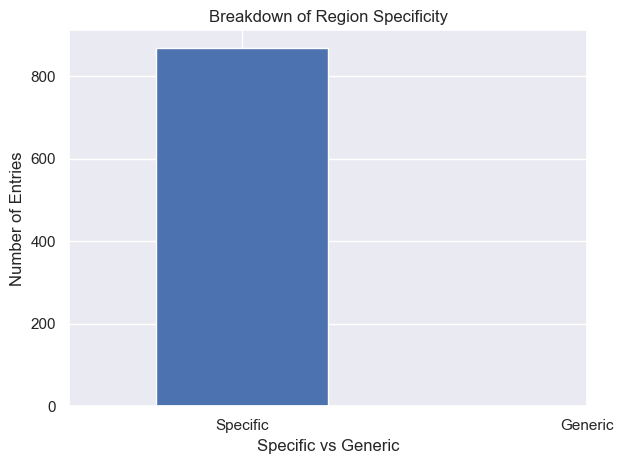

In [120]:
df['Specific vs Generic'] = df['target'].str.lower().isin(generic_labels)
df['Specific vs Generic'].value_counts().plot(kind='bar')
plt.xticks([0, 1], ['Specific', 'Generic'], rotation=0)
plt.title('Breakdown of Region Specificity')
plt.ylabel('Number of Entries')
plt.tight_layout()
plt.show()


Creating a new column called targe_generic to store the generic target data in.

In [115]:
# List of generic directional terms
generic_keywords = ['south', 'east', 'north', 'west', 'central']

# Create a regex pattern to match any of them (case-insensitive)
import re
pattern = '|'.join(generic_keywords)

# Move partial matches to target_generic
df['target_generic'] = df['target'].where(df['target'].str.contains(pattern, case=False, na=False))

# Keep only specific values in 'target'
df['target'] = df['target'].where(~df['target'].str.contains(pattern, case=False, na=False))


once again comparing the target regions

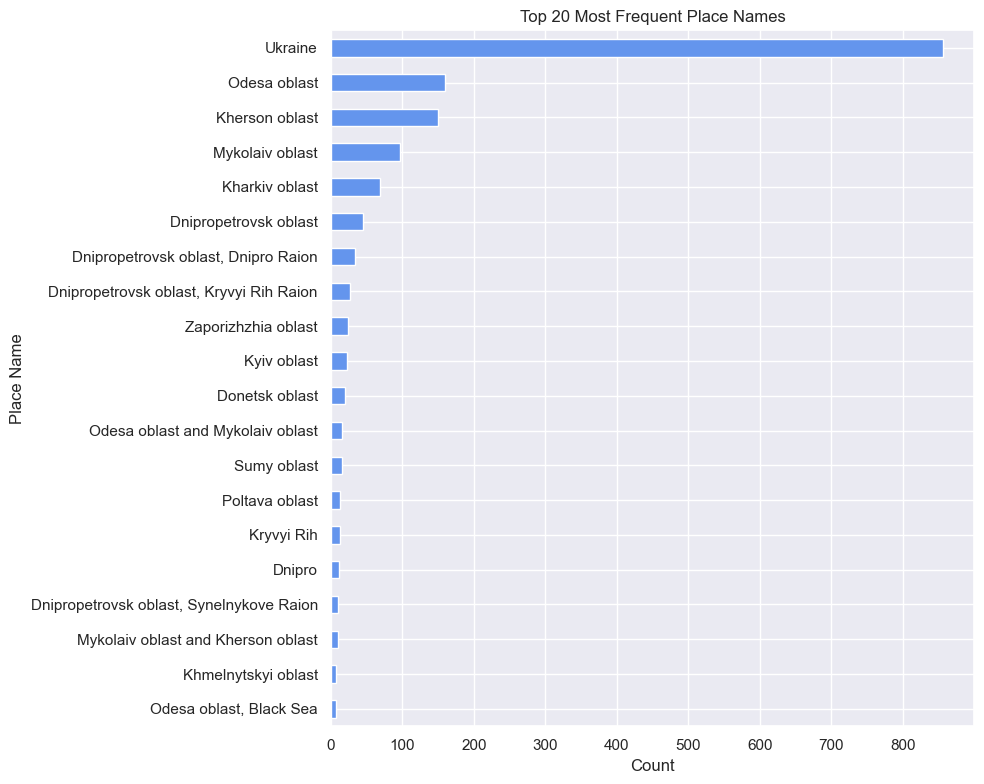

In [116]:
top_places = df['target'].value_counts().head(20)
top_places.plot(kind='barh', figsize=(10, 8), color='cornflowerblue')

plt.xlabel('Count')
plt.ylabel('Place Name')
plt.title('Top 20 Most Frequent Place Names')
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()


### Creating two separate specially designed datasets for solving the problems

Creating the Linear regression dataset as a seperate csv for solving the how many attacks next month problem

In [122]:

# Create new dataframe for the linear regression problem
linear_regression_df = df[['time_start', 'launched', 'model']].copy()

# This column contains the launched value from the next row (i.e., the "future" value)
linear_regression_df['launched_next_month'] = linear_regression_df['launched'].shift(-1)


# Save to csv
linear_regression_df.to_csv('linear_regression_dataset.csv', index=False)


Creating the K-means dataset as a seperate csv for solving most attackeck region problem

In [123]:
# Create new dataframe for the K-Means problem
kmeans_df = df[['target', 'launched', 'destroyed', 'still_attacking', 'not_reach_goal']]

# Save to csv
kmeans_df.to_csv('kmeans_dataset.csv', index=False)

In [121]:
df.columns

Index(['time_start', 'time_end', 'model', 'launch_place', 'target', 'carrier',
       'launched', 'destroyed', 'not_reach_goal', 'cross_border_belarus',
       'back_russia', 'still_attacking', 'affected region',
       'destroyed_details', 'launched_details', 'launch_place_details',
       'source', 'Specific vs Generic', 'target_generic'],
      dtype='object')